In [16]:
#Inspired by https://avandekleut.github.io/vae/
import torch;
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [18]:
class FF(nn.Module):
    def __init__(self,dim1,dim2,dim3):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=dim1, out_features=dim2),
            nn.ReLU(),
            nn.Linear(in_features=dim2, out_features=dim3)
        )

    def forward(self, input):
        return self.main(input)
tmp = FF(28*28,512,2)
print(tmp)
print(tmp(torch.rand(10,1,28*28)).shape)

FF(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)
torch.Size([10, 1, 2])


In [19]:
class Autoencoder(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super().__init__()
        self.encoder = FF(dim1, dim2, dim3)
        self.decoder = nn.Sequential(
            FF(dim3, dim2, dim1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
tmp = Autoencoder(28*28,512,2)
print(tmp)
print(tmp(torch.rand(10,1,28*28)).shape)
print(summary(tmp, (1,28*28)))

Autoencoder(
  (encoder): FF(
    (main): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=2, bias=True)
    )
  )
  (decoder): Sequential(
    (0): FF(
      (main): Sequential(
        (0): Linear(in_features=2, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
    (1): Sigmoid()
  )
)
torch.Size([10, 1, 784])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         401,920
              ReLU-2               [-1, 1, 512]               0
            Linear-3                 [-1, 1, 2]           1,026
                FF-4                 [-1, 1, 2]               0
            Linear-5               [-1, 1, 512]           1,536
              ReLU-6               [-1, 1, 512]               0
 

In [5]:
def train(data_loader, model, optimizer, loss_function, epochs=20):
    model.to(device) # GPU
    losses = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device) # GPU
            optimizer.zero_grad()
            x_hat = model(x)
            loss = loss_function(x, x_hat)
            losses.append(loss.clone().detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"{epoch}/{i}: {loss}")
    return (model, losses)

In [6]:
def plot_latent(data_loader, encoder, dim1=0, dim2=1, num_batches=100):
    for i, (x, y) in enumerate(data_loader):
        z = encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0, dim1], z[:, 0, dim2], c=y, alpha=0.5)
        if i > num_batches:
            plt.colorbar()
            break

In [7]:
def plot_reconstructed(decoder, w, h, r0=(-10, 10), r1=(-10, 10), n=12):
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).view(1,1,2).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(w, h).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [8]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x,start_dim=-2))
])

data = datasets.MNIST('./data',transform=transform,download=True)

n, w, h = data.data.shape

data_loader = torch.utils.data.DataLoader(data,batch_size=128,shuffle=True)

model = Autoencoder(w*h, 512, 2)

optimizer = torch.optim.Adam(model.parameters())
    
loss_function = torch.nn.MSELoss()

(autoencoder, losses) = train(data_loader, model, optimizer, loss_function,20)

RuntimeError: Given groups=1, weight of size [8, 1, 3, 3], expected input[1, 128, 1, 784] to have 1 channels, but got 128 channels instead

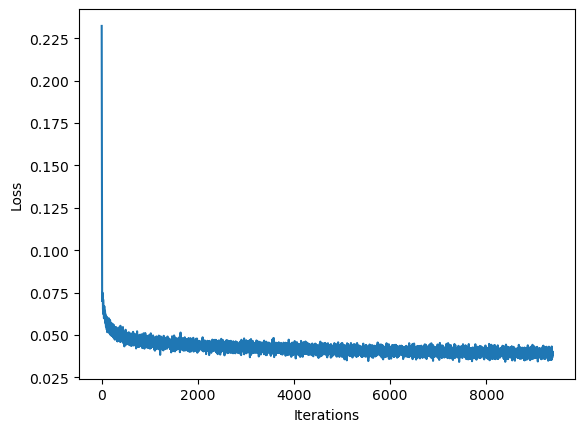

In [19]:
 # Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the losses
plt.plot(losses)

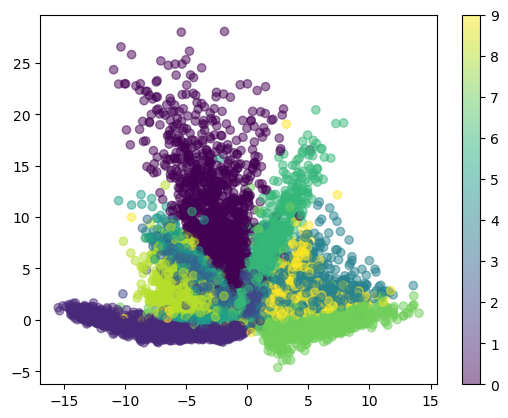

In [20]:
# Plot latent space
plot_latent(data_loader, autoencoder.encoder)
plt.savefig('latent.png')

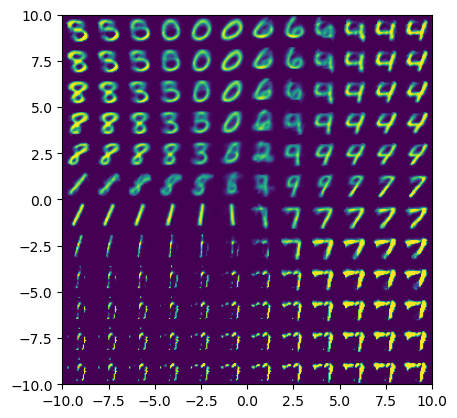

In [21]:
# Generate samples from latent space
plot_reconstructed(autoencoder.decoder,w,h)
plt.savefig('reconstruction.png')